In [14]:
import numpy as np
import pandas as pd
from math import sin
import matplotlib.pyplot as plt
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/Users/jonathanhilgart/anaconda/envs/stats/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['sin']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


- Maximize the log probability of y given the parameters of the kernel
- Reference: https://math.stackexchange.com/questions/1030534/gradients-of-marginal-likelihood-of-gaussian-process-with-squared-exponential-co/1072701#1072701
- $lnP(y|x,θ)=−1/2*ln|K|−1/2*ytK−1y−N2ln2π$

- Define the kernel

In [15]:
def rbf( a, b, param=2.0, train=False,
                            train_noise = 5e-3, vertical_scale=1.5):
        """Calculated the squarred exponential kernel.
        Adds a noise term for the covariance of the training data
        Adjusting the param changes the difference where points will have a positive covariance
        Returns a covaraince Matrix.
        Vertical scale controls the vertical scale of the function"""


        if train == False:
            # ensure a and b are numpy arrays
            a = np.array(a)
            b = np.array(b)
            sqdist = np.sum(a**2,1).reshape(-1,1) + np.sum(b**2,1) - 2*np.dot(a, b.T)
            return vertical_scale*np.exp(-.5 * (1/param) * sqdist)

        else:
            # ensure a and b are numpy arrays
            a = np.array(a)
            b = np.array(b)
            noisy_observations = train_noise*np.eye(len(a))
            sqdist = np.sum(a**2,1).reshape(-1,1) + np.sum(b**2,1) - 2*np.dot(a, b.T)
            return vertical_scale*np.exp(-.5 * (1/param) * sqdist) + noisy_observations

- Define the RBF gradients

In [87]:
def rbf_grad_theta(a,b, theta = 1.5, length = 2.0):
    """Computes the derivative of the RBF kernel wrt the theta parameter.
    Only use with the training points (points that have a corresponding y-value)"""
    sqdist = np.sum(a**2,1).reshape(-1,1) + np.sum(b**2,1) - 2*np.dot(a, b.T)

    return 2*theta*np.exp( - sqdist / (2*length**2 ))

In [88]:
def rbf_grad_length(a,b, theta = 1.5, length = 2.0 ):
    """COmputes the derivative of the RBF kernel wrt the length parameter.
    Only use with the training points (points that have a corresponding y-value
    """
    sqdist = np.sum(a**2,1).reshape(-1,1) + np.sum(b**2,1) - 2*np.dot(a, b.T)
    
    return theta**2 * np.exp(-sqdist / (2*length**2)  )* ( sqdist / length**3)

- Define test points

In [47]:
test_x = np.array(np.linspace(-100,100,1_000)).reshape(-1,1)
train_x = np.array([[-5,10,40]]).reshape(-1,1)

train_y_func = lambda x: 1000*sin(.1*x)/abs(x+10*x+5)
train_y_func_two_d = lambda a,b : (a*b)/(a-1/(b+1)) - b
train_y_numbers = np.array([train_y_func(_) for _ in train_x]).reshape(-1,1)
y_var = 100
max_covariance = 5


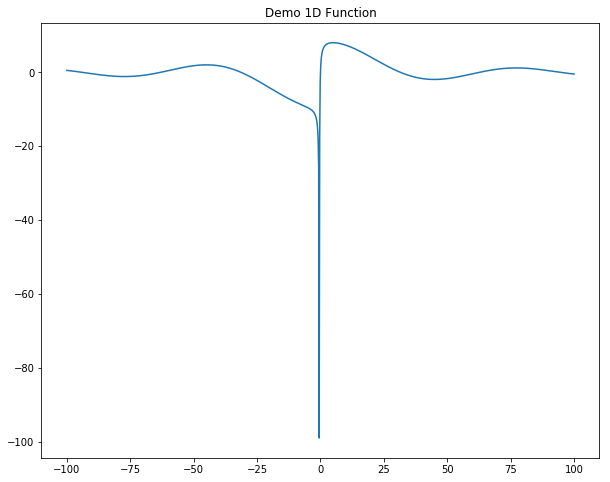

In [48]:
plt.figure(figsize=(10,8))
plt.title('Demo 1D Function')
plt.plot(np.linspace(-100,100,1_000),np.array([train_y_func(_) for _ in test_x]).reshape(-1,1) );

### Test the gradients
- returns a matrix of first derivatives

In [94]:
rbf_grad_theta(train_x,test_x)

array([[  0.00000000e+000,   0.00000000e+000,   0.00000000e+000, ...,
          0.00000000e+000,   0.00000000e+000,   0.00000000e+000],
       [  0.00000000e+000,   0.00000000e+000,   0.00000000e+000, ...,
          0.00000000e+000,   0.00000000e+000,   0.00000000e+000],
       [  0.00000000e+000,   0.00000000e+000,   0.00000000e+000, ...,
          4.40835314e-193,   2.22134600e-194,   1.10816492e-195]])

In [97]:
rbf_grad_length(train_x,test_x)

array([[  0.00000000e+000,   0.00000000e+000,   0.00000000e+000, ...,
          0.00000000e+000,   0.00000000e+000,   0.00000000e+000],
       [  0.00000000e+000,   0.00000000e+000,   0.00000000e+000, ...,
          0.00000000e+000,   0.00000000e+000,   0.00000000e+000],
       [  0.00000000e+000,   0.00000000e+000,   0.00000000e+000, ...,
          1.46802800e-190,   7.44709589e-192,   3.74005661e-193]])

# Define the gradient of the marginal log-likelihood

In [134]:
def marginal_log_likehood_grad(covariance_matrix, y_values, cov_gradient_matrix):
    """
    covaraince_matrix: the covaraince given the kernel 
    y_values: returning y-vals from the underlying function
    cov_gradient_matrix: the jacobian matrix for the given parameter
    
    return the gradient of the marginal log-likelihood"""
    
    return 1/2 * y_values.T @ np.linalg.inv(covariance_matrix) @  cov_gradient_matrix @np.linalg.inv(covariance_matrix)\
            @ y_values -\
            .5* np.trace(np.linalg.inv(covariance_matrix) @ cov_gradient_matrix)

In [135]:
cov_train_train = rbf(train_x,train_x)

In [140]:
length_grad = rbf_grad_length(train_x,train_x)
theta_grad = rbf_grad_theta(train_x,train_x)

In [137]:
marginal_log_likehood_grad(cov_train_train,train_y_numbers, length_grad )

array([[ -1.20407265e-09]])

In [141]:
marginal_log_likehood_grad(cov_train_train,train_y_numbers, theta_grad  )

array([[ 95.91491574]])

In [115]:
.5* train_y_numbers.T

array([[-4.79425539,  3.6585695 , -0.85033988]])

In [131]:
.5* train_y_numbers.T @ np.linalg.inv(cov_train_train) @ cov_train_train @ np.linalg.inv(cov_train_train) 

array([[-3.19617026,  2.43904633, -0.56689325]])

In [133]:
train_y_numbers

array([[-9.58851077],
       [ 7.317139  ],
       [-1.70067976]])